## **Credit card fraud dection** 



## Table of Contents
- [Objectives](#Objectives)
- [Data-Preparation](#Data-Preparation)
- [Scenario](#Scenario)
- [**Random-Forest-Classifier**](#Random-Forest-Classifier)
- [**Gradient-Boosting-Classifier**](#Gradient-Boosting-Classifier)
- [**XGBoost**](#XGBoost)


# Objectives

Using exploring more advanced (ensemble) models to detect credit card fraud.

Exploring:
- Random Forest
- Gradient Boosting
- Isolation Forests



# Data-Preparation

### Importing Required Libraries

Libraries required for this notebook will be imported here

In [2]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Load in data

Data used: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [3]:
data = pd.read_csv("..\data\kaggel_credit_card_fraud_detection\creditcard.csv")
data.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


### Split data into training and testing set

In [4]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["Class"])
y = data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
X_train.shape, X_test.shape, y_train.shape, y_test.shape  

((227845, 30), (56962, 30), (227845,), (56962,))

In [5]:
#check amounts of fraud and non-fraud
y_train.value_counts(), y_test.value_counts()

(Class
 0    227451
 1       394
 Name: count, dtype: int64,
 Class
 0    56864
 1       98
 Name: count, dtype: int64)

### Standardise data

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Create model performance assessment function

In [7]:
def assess_model_performance(y_true, y_pred, model_name):    
    report = classification_report(y_true, y_pred, target_names=['Non-Fraud', 'Fraud'])
    print(f"Model: {model_name}\n{report}")
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
                xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Scenario

Predict credit card fraud various ML models, creating, testing and validating them

### Data Description ###

The dataset used for this visualization project contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Features V1-V28 have been deduced by PCA, and have names omitted due to confidentiality

The dataset includes the following variables:
<br>1. Time: Seconds elapsed between each transaction and the first transaction in the dataset.
<br>2-29. V1 - V28: Anonymised features deduced by PCA
<br>30. Amount: transaction Amount, this feature can be used for example-dependant cost-sensitive learning
<br>31. Class: Responce varialbe for fraud classification (0 = not fraud, 1 = fraud)




# Random-Forest-Classifier

# Model-Building

## Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=10,
    oob_score=True,
    random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)



C:\Users\aiden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


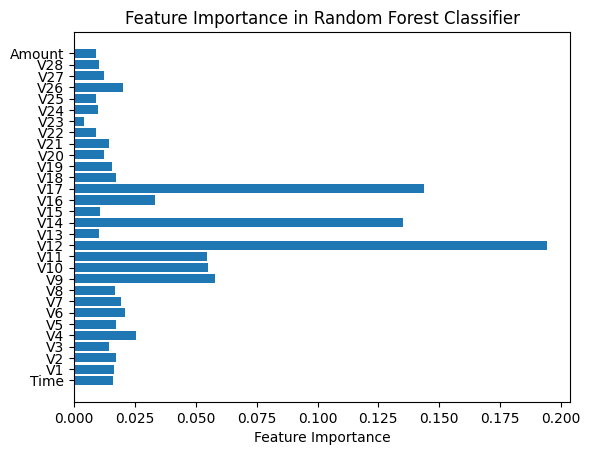

In [9]:
feature_importances = rf.feature_importances_

plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

# Evaluation

Model: Random Forest Classifier
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.96      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.96%


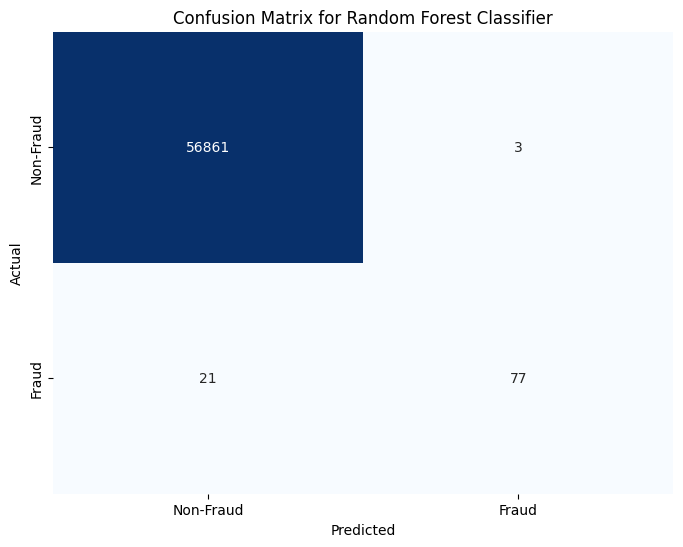

In [10]:
assess_model_performance(y_test, y_pred, "Random Forest Classifier")

Great accuracy on detecting non-fraud, needs tuning to better detect fraud.

# Model-Improvement


Basic model works better but can be improved. GridSearch will be used to tune model hyperparameters.



No improvement in fraud detection despite hyperparameter optimisation. Removed from notebook for speed. The focus should be on improving recall on fraud case with the following:
 - Class weighting: Put a greater emphasis on the fraud class
 - Feature importance analysis: Bias more predictive features and/or drop noisy features
 - SMOTE or ADASYN: Synthetic oversampling to help boost recall for the fraud class
 - Threshold tuning: Adjust the decision threshold to improve sensitivity to fraud
 - Cost-sensitive evaluation: Evaluate with metrics like precision-recall AUC 

In [11]:
#Add class_weight to handle class imbalance
rf_balanced = RandomForestClassifier(
    n_estimators=10,
    oob_score=True,
    class_weight='balanced',
    random_state=1)
rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)

C:\Users\aiden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Model: Random Forest Classifier w Class Weighting
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.96      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.96%


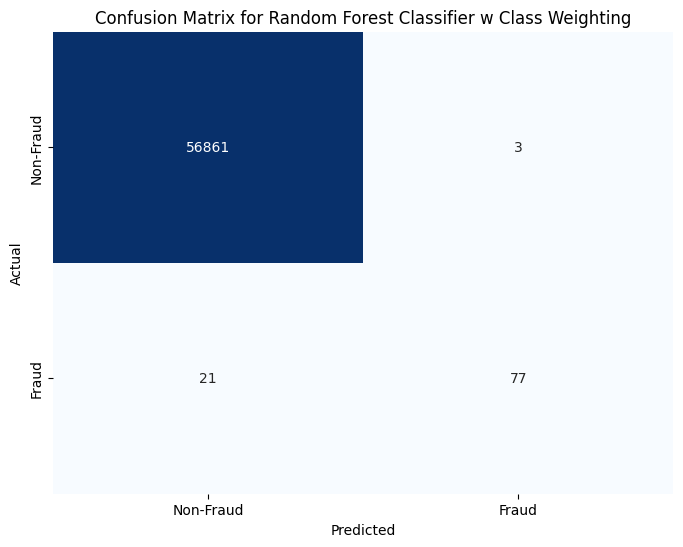

In [12]:
assess_model_performance(y_test, y_pred, "Random Forest Classifier w Class Weighting")

'Balanced' class weight did not improve Fraud recall. Try setting my own class balance.

In [13]:
#make fraud (class 1) 20x more important
rf_balanced = RandomForestClassifier(
    n_estimators=10,
    oob_score=True,
    class_weight={0: 1, 1: 20}, 
    random_state=1)

rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)



C:\Users\aiden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Model: Random Forest Classifier with 20x Fraud Weighting
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.99      0.72      0.84        98

    accuracy                           1.00     56962
   macro avg       0.99      0.86      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.95%


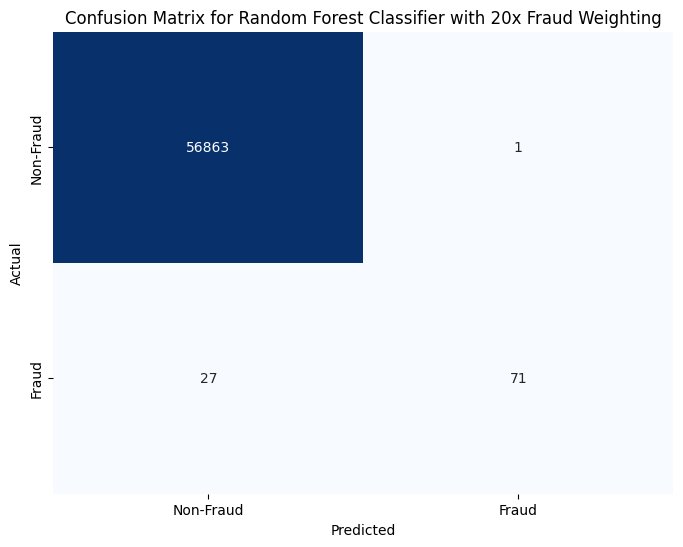

In [14]:
assess_model_performance(y_test, y_pred_balanced, "Random Forest Classifier with 20x Fraud Weighting")

Class balancing is not working well. Consider the decision threshold tuning.

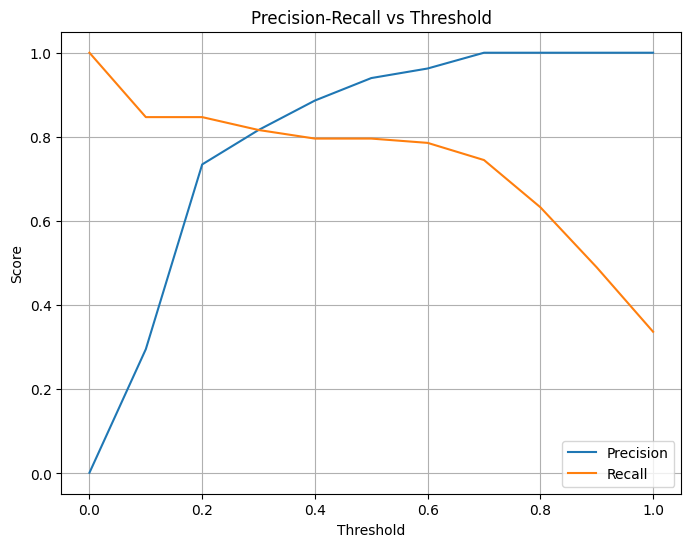

In [15]:
from sklearn.metrics import precision_recall_curve

probs = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

Optimal threshold looks to be around 0.3 - try this then see assess model performance

Model: Random Forest Classifier with Custom Threshold (0.3)
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.94%


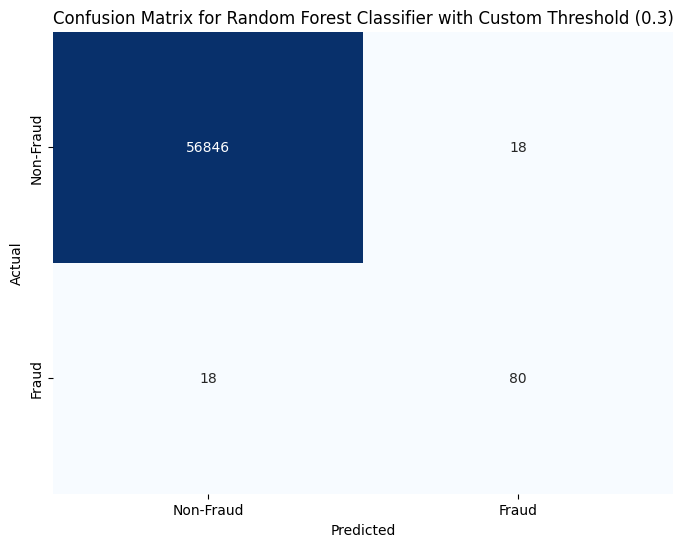

In [16]:
# Get predicted probabilities for the positive class (fraud)
y_probs = rf.predict_proba(X_test)[:, 1]

# Apply custom threshold (e.g. 0.3 instead of 0.5)
threshold = 0.3
y_pred_custom = (y_probs >= threshold).astype(int)

assess_model_performance(y_test, y_pred_custom, "Random Forest Classifier with Custom Threshold (0.3)")

Adjusting the decision threshold to 0.3 has slightly improved recall of the fraud class. 

In [17]:
#test significance of recall improvement
from scipy.stats import ttest_ind
from sklearn.metrics import recall_score
# Assuming y_test and y_pred_custom are defined
recall_custom = recall_score(y_test, y_pred)
recall_balanced = recall_score(y_test, y_pred_custom)
t_stat, p_value = ttest_ind(y_test[y_pred == 1], y_test[y_pred_custom == 1])
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 3.069350387014549, P-value: 0.002485142004880419


Small P-value indicates significant improvement in Fraud recall by implementing a decision threshold of 0.3. This model has better Fraud and non-Fraud recall than the simpile logistic regression build.

# **Gradient-Boosting-Classifier**

In [18]:
#create a Gradient Boost model with starting parameters
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=3,
    learning_rate=.1,
    random_state=1)

gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)




Model: Gradient Boosting Classifier
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.74      0.68      0.71        98

    accuracy                           1.00     56962
   macro avg       0.87      0.84      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.91%


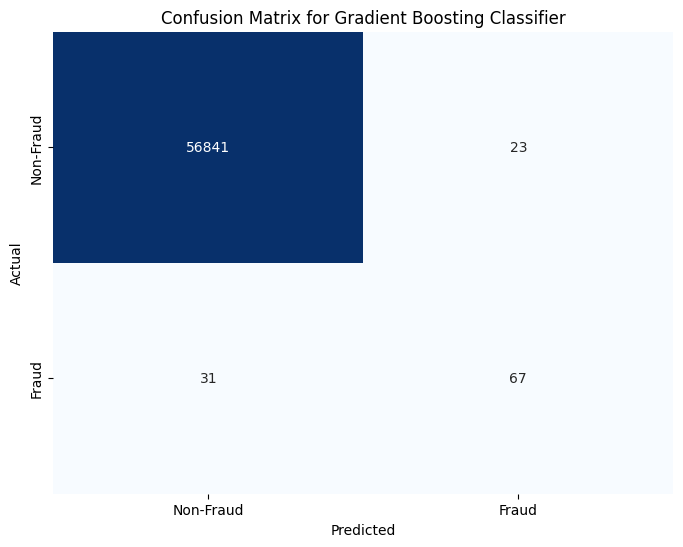

In [19]:
assess_model_performance(y_test, y_pred_gbm, "Gradient Boosting Classifier")

Base GBoost model has worse poorer Fraud & Non-Fraud Precision and Recall (while also talking longer to run) the Random Forest. Look for ways to improve the GBoost model performance.

In [20]:
weighted_gbm = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=3,
    learning_rate=.1,
    random_state=1,
    )

# Fit the model with sample weights. Higher weight of 10 assigned to fraud cases (class 1)
weighted_gbm.fit(X_train, y_train, sample_weight=y_train.map({0: 1, 1: 10}))
y_pred_weighted_gbm = weighted_gbm.predict(X_test)

Model: GBoost Classifier with x10 Fraud Weighting
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.80      0.83      0.81        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.94%


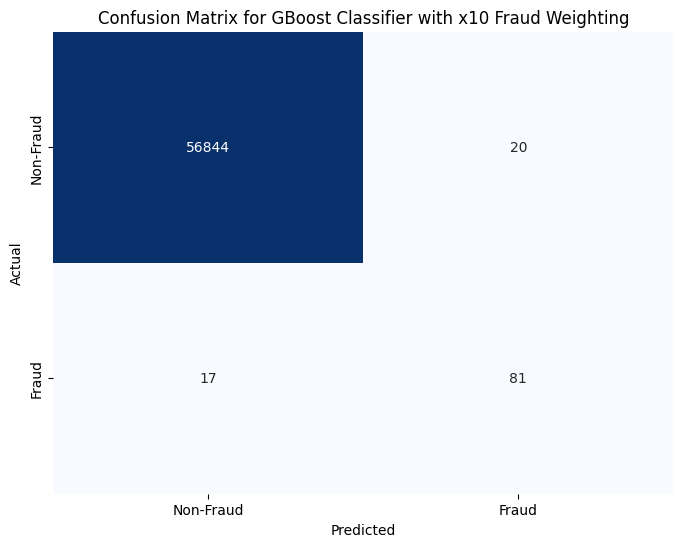

In [21]:
assess_model_performance(y_test, y_pred_weighted_gbm, "GBoost Classifier with x10 Fraud Weighting")

Substantial improvement in Fraud recall after weighting the GBoost model, try a higher weight

In [22]:

# Fit the model with sample weights. Higher weight of 10 assigned to fraud cases (class 1)
y_pred_weighted_gbm = weighted_gbm.fit(X_train, y_train, sample_weight=y_train.map({0: 1, 1: 15})).predict(X_test)


Model: GBoost Classifier with x15 Fraud Weighting
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.85      0.81      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.94%


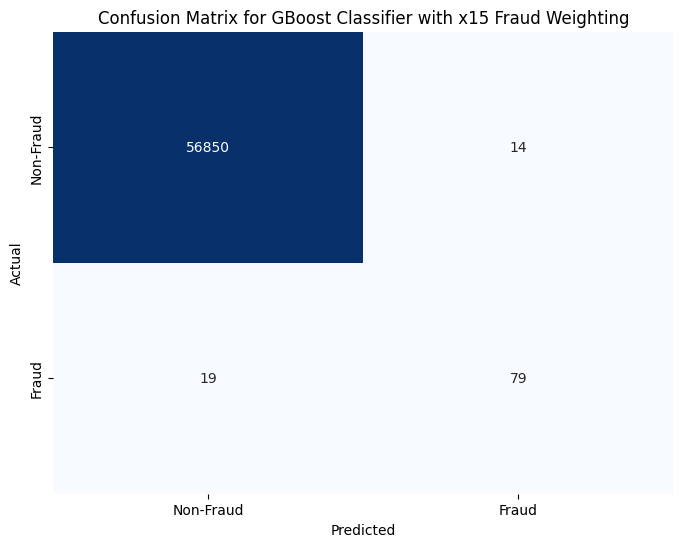

In [23]:
assess_model_performance(y_test, y_pred_weighted_gbm, "GBoost Classifier with x15 Fraud Weighting")

No improvement with x15 weighting of Fraud class, try x5 weighting

Model: GBoost Classifier with x5 Fraud Weighting
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.94%


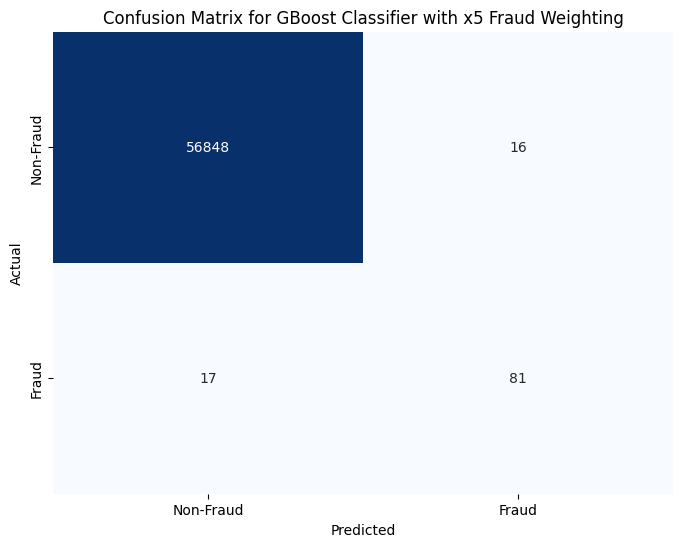

In [24]:
y_pred_weighted_gbm = weighted_gbm.fit(X_train, y_train, sample_weight=y_train.map({0: 1, 1: 5})).predict(X_test)
assess_model_performance(y_test, y_pred_weighted_gbm, "GBoost Classifier with x5 Fraud Weighting")

With x5 Fraud weighting, precision and recall of both non-Fraud and Fraud classification are in good states. Adjusting decision thresfold to see if there are small improvements.

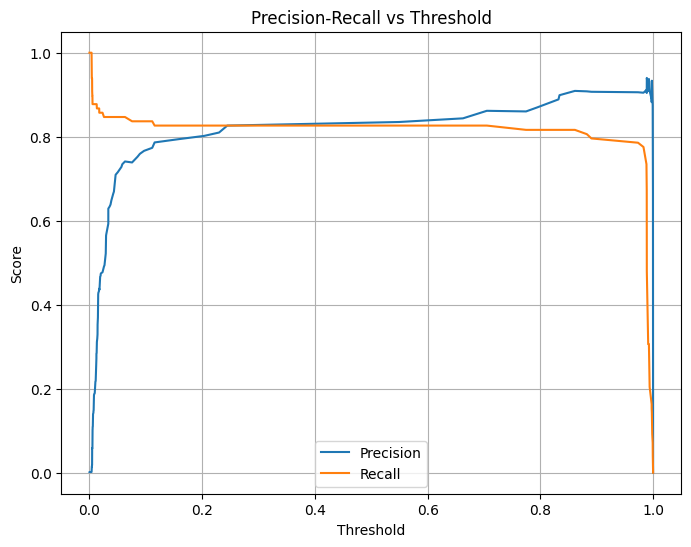

In [25]:
probs = weighted_gbm.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

Presicion and recall of classification have no major threshold. I will implement a custom threshold but there will be litte/no improvement

Model: GBoost Classifier with Custom Threshold (0.3)
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.94%


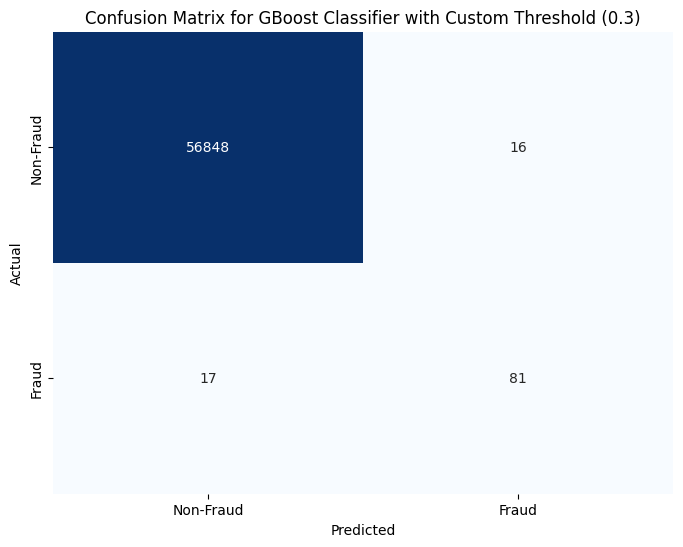

In [26]:
#apply custom threshold
threshold = 0.3
y_pred_custom = (probs >= threshold).astype(int)
assess_model_performance(y_test, y_pred_custom, "GBoost Classifier with Custom Threshold (0.3)")

Good accuracy on GBoost model, time to try XGBoost

# **XGBoost**

In [37]:
from xgboost import XGBClassifier

# Create an XGBoost classifier with starting parameters
xgb = XGBClassifier(
    n_estimators=10,
    max_depth=3,
    learning_rate=.1,
    random_state=1)

Model: XGBoost Classifier
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.83      0.79      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.89      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.94%


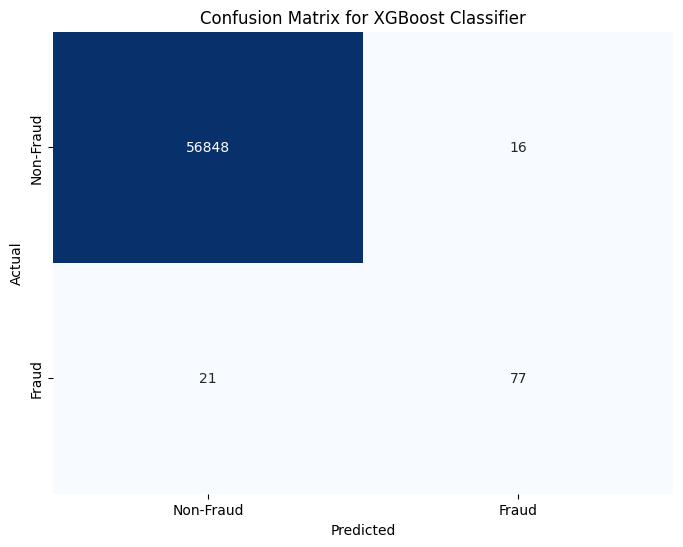

In [38]:
y_pred_xgb = xgb.fit(X_train, y_train).predict(X_test)
assess_model_performance(y_test, y_pred_xgb, "XGBoost Classifier")

Better intital model performance than GBoost on Fraud recall, but can be improved with class weighting and threshold tuning

Model: XGBoost Classifier with x10 Fraud Weighting
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.78      0.83      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.93%


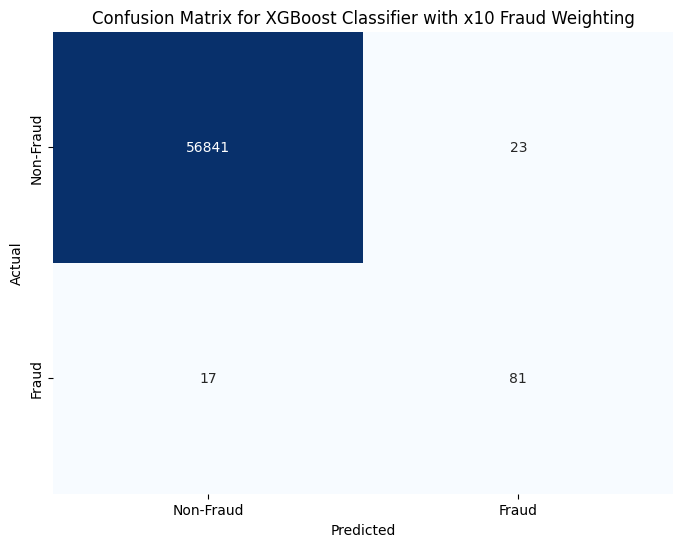

Model: XGBoost Classifier with x15 Fraud Weighting
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.79      0.85      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.94%


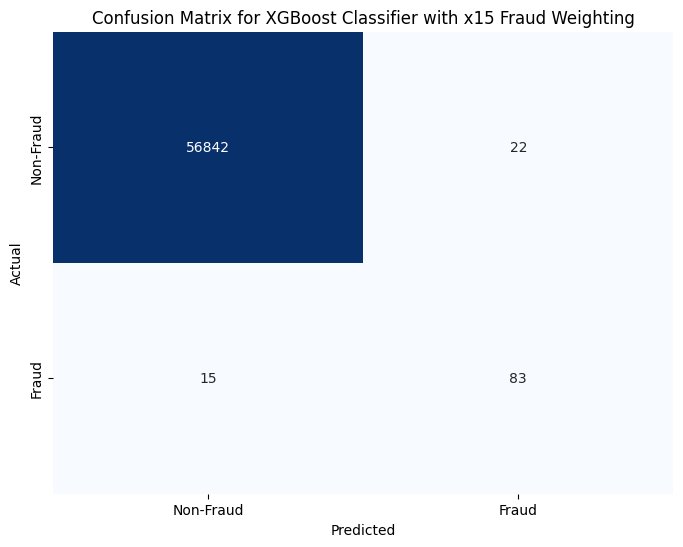

Model: XGBoost Classifier with x5 Fraud Weighting
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 99.94%


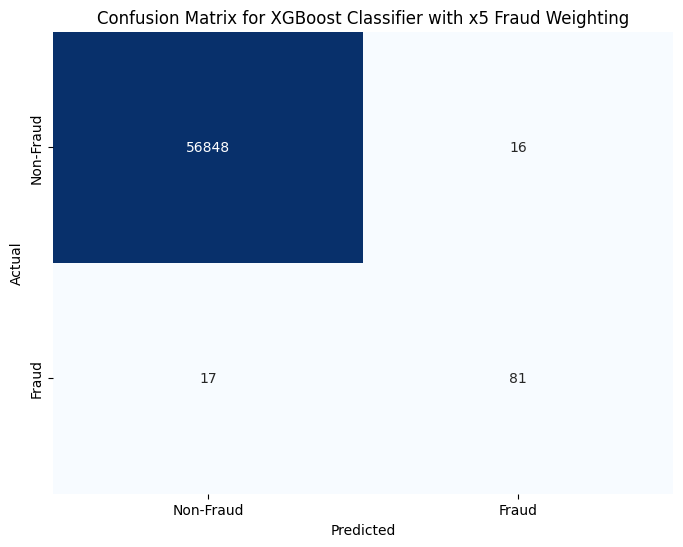

In [39]:

y_pred_xgb_weighted_10 = xgb.fit(X_train, y_train, sample_weight=y_train.map({0: 1, 1: 10})).predict(X_test)
y_pred_xgb_weighted_15 = xgb.fit(X_train, y_train, sample_weight=y_train.map({0: 1, 1: 15})).predict(X_test)
y_pred_xgb_weighted_5 = xgb.fit(X_train, y_train, sample_weight=y_train.map({0: 1, 1: 5})).predict(X_test)
assess_model_performance(y_test, y_pred_xgb_weighted_10, "XGBoost Classifier with x10 Fraud Weighting")
assess_model_performance(y_test, y_pred_xgb_weighted_15, "XGBoost Classifier with x15 Fraud Weighting")
assess_model_performance(y_test, y_pred_xgb_weighted_5, "XGBoost Classifier with x5 Fraud Weighting")

A x15 Fraud class weighting gave better Fraud Recall, though it introduced a greater type II error, whereas the x5 weighting has a better balance of perfomance metrics. Despite the x15 model having better Fraud recall, I will chose the x5 Model is it has a better overall balance of Fraud/Non-Fraud prediction


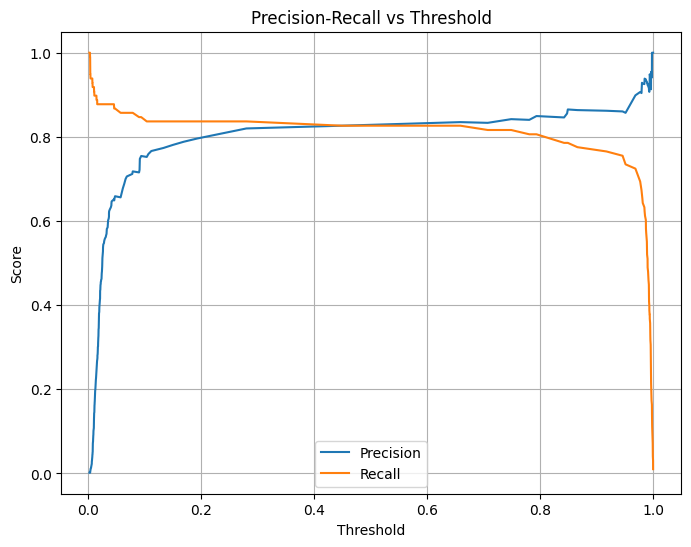

In [40]:
probs = xgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

Precision-Recall intersection is around 0.5 so there is little reason to change the decision threshold to improve fraud recall.